In [1]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize, stats
from matplotlib.colors import LinearSegmentedColormap, Normalize

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

In [2]:
# Grid search parameters
ll_r = np.linspace(0.01, 0.99, 99)
alpha = 1e-5

# A first example

In [3]:
M = 2500000
p = 500

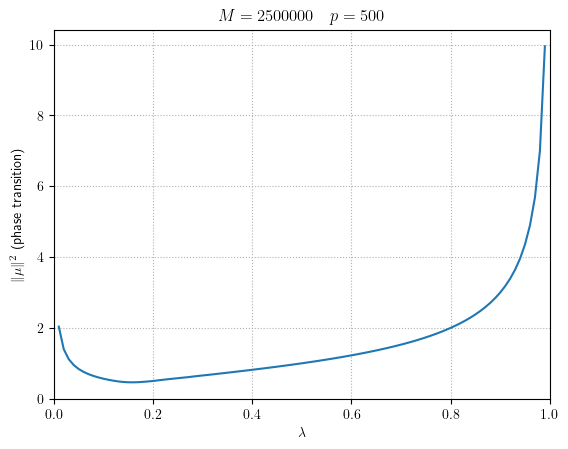

In [4]:
r = M/(p*p)
func = lambda ll: utils.phi(ll/(1-ll), 2*ll*ll*r/(1-ll))
grid = np.array([func(ll) for ll in ll_r])

plt.plot(ll_r, grid)
plt.grid(ls=':')
plt.xlim(0, 1)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\| \\mu \\|^2$ (phase transition)")
plt.title("$M = {} \\quad p = {}$".format(M, p));

In [5]:
ll_argmin = ll_r[np.argmin(grid)]
a, b = max(alpha, ll_argmin-0.01), min(1-alpha, ll_argmin+0.01)
res = optimize.minimize_scalar(func, bracket=(a, b), method='brent')
print(res)
print("L = {}".format(res.x*M/p))
print("n = {}".format((1-res.x)*p/res.x))
print("c = {}".format(res.x/(1-res.x)))
print("eps = {}".format(2*res.x*res.x*r/(1-res.x)))

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 0.46267424132605384
       x: 0.15735093178727844
     nit: 9
    nfev: 12
L = 786.7546589363922
n = 2677.6106713873564
c = 0.18673364479121
eps = 0.5876542600786313


# Performance

In [6]:
memr = np.logspace(-2, 2, 200)
opt_ll = np.empty_like(memr)*np.nan
pht = np.empty_like(memr)*np.nan

In [7]:
for i, r in enumerate(tqdm(memr)):
    func = lambda ll: utils.phi(ll/(1-ll), 2*ll*ll*r/(1-ll))
    grid = np.array([func(ll) for ll in ll_r])
    ll_argmin = ll_r[np.argmin(grid)]
    a, b = max(alpha, ll_argmin-0.01), min(1-alpha, ll_argmin+0.01)
    res = optimize.minimize_scalar(func, bracket=(a, b), method='brent')
    if res.success:
        opt_ll[i] = res.x
        pht[i] = res.fun
opt_eps = (2*(opt_ll**2)*memr)/(1-opt_ll)

100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


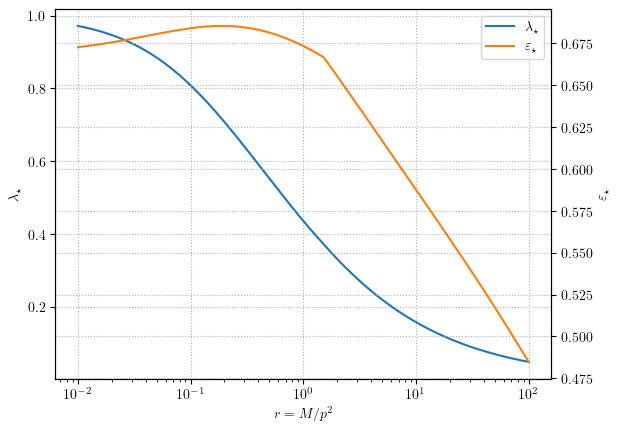

In [8]:
fig = plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()

plot1 = ax1.plot(memr, opt_ll, color='C0', label="$\\lambda_\\star$", zorder=3)
ax1.grid(ls=':', zorder=2)
ax1.set_xscale('log')
ax1.set_xlabel("$r = M / p^2$")
ax1.set_ylabel("$\\lambda_\\star$")

plot2 = ax2.plot(memr, opt_eps, color='C1', label="$\\varepsilon_\\star$", zorder=3)
ax2.grid(ls=':', zorder=2)
ax2.set_ylabel("$\\varepsilon_\\star$")

plots = plot1+plot2
labels = [plot.get_label() for plot in plots]
ax2.legend(plots, labels);

In [9]:
left, right = memr.min(), memr.max()
top = np.sqrt(opt_ll[0]/(1-opt_ll[0]))
mu2r = np.linspace(0, top, 200)
zeta0 = np.zeros((memr.size, mu2r.size))
lr = np.arange(1, 10000)

for i, ll in enumerate(tqdm(opt_ll)):
    for j, mu2 in enumerate(mu2r):
        if mu2 > 0:
            zeta0[i, j] = mu2*(1-ll*(mu2**(-2)+2*np.sum(((mu2+1)/np.sinc(opt_eps[i]*lr)-1)**(-2)))/(1-ll))/(mu2+1)

error_rate = lambda zeta: stats.norm.sf(np.sqrt(zeta/(1-zeta))) # asymptotic online clustering error
online_err = error_rate(np.maximum(zeta0, 0))

100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


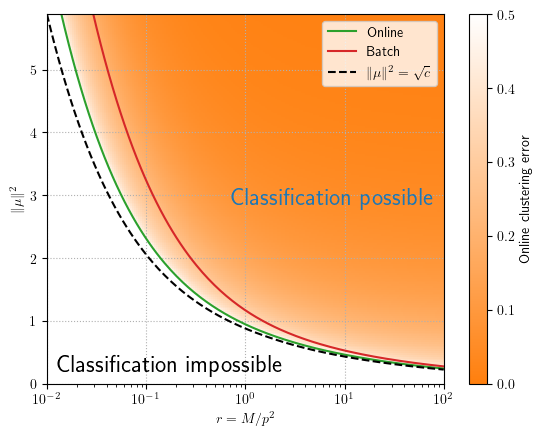

In [10]:
cmap = LinearSegmentedColormap.from_list('test', ['C1', 'white'])
plt.plot(memr, pht, color='C2', label="Online")
plt.plot(memr, 1/np.sqrt((np.sqrt(2*memr+1)-1)), color='C3', label="Batch")
plt.plot(memr, np.sqrt(opt_ll/(1-opt_ll)), ls='--', color='black', label="$\\| \\mu \\|^2 = \\sqrt{c}$")
mesh = plt.pcolormesh(memr, mu2r, online_err.T, norm=Normalize(0, 0.5), cmap=cmap, alpha=1)
cbar = plt.colorbar(mesh, orientation='vertical')
cbar.set_label("Online clustering error")
plt.grid(ls=':')
plt.xscale('log')
plt.xlim(left, right)
plt.ylim(0, top)
plt.text(right*10**(-0.1), top/2, "Classification possible", color='C0', fontsize='xx-large', fontweight='bold', ha='right', va='center')
plt.text(left*10**(0.1), top/20, "Classification impossible", color='black', fontsize='xx-large', fontweight='bold', ha='left', va='center')
plt.xlabel("$r = M / p^2$")
plt.ylabel("$\\| \\mu \\|^2$")
plt.legend();